<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess annotated mouse brain single-cell data from Tabula Muris (Schaum 2018 Nature)

In [1]:
import datetime
datetime.date.today().strftime('%d/%m/%Y')

'22/01/2024'

In [2]:
import os
os.getlogin()

'simonf'

In [3]:
import sys
import fnmatch 

In [4]:
import anndata
import scanpy as sc
import scipy as sci
#sc.logging.print_versions()

In [5]:
sc.settings.verbosity = 3

In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import platform
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [7]:
from matplotlib.pyplot import rc_context

In [8]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [9]:
platform.platform()

'macOS-14.2.1-arm64-arm-64bit'

In [10]:
os.getcwd()

'/Volumes/BD-Dichgans/SF/Git/p06/foxf2-per-celltype'

In [11]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win
main_dir='/Volumes/BD-Dichgans/SF'# Mac

# Load + format data

## Annotated by authors

Parts of the code gratefully based on https://github.com/theislab/scib-reproducibility/blob/main/notebooks/data_preprocessing/mouse_brain/01_collect_mouse_brain_studies.ipynb

(see SF/P6_vasc_scRNAseq/DropViz/all_by_region/)

Using FACS sorted cells, from:  
 -Brain_Myeloid-counts.csv  
 -Brain_Non-Myeloid-counts.csv

Publication: https://www.nature.com/articles/s41586-018-0590-4  
Downloaded from: https://figshare.com/articles/dataset/Single-cell_RNA-seq_data_from_Smart-seq2_sequencing_of_FACS_sorted_cells/5715040

In [12]:
# adata_tamu_myel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Myeloid-counts.csv').T

In [13]:
# adata_tamu_nonmyel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Non-Myeloid-counts.csv').T

In [14]:
# download source differs somehow to the one used by Maren Buettner. I assume Brain_Myeloid-counts equals Brain_Microglia-counts.csv.

In [15]:
adata_tamu_myel = sc.read_csv(main_dir+'/P06_vasc_scRNAseq/TabulaMuris2018/FACS/Brain_Microglia-counts.csv').T

In [16]:
adata_tamu_nonmyel = sc.read_csv(main_dir+'/P06_vasc_scRNAseq/TabulaMuris2018/FACS/Brain_Neurons-counts.csv').T

In [17]:
adata_tamu_myel

AnnData object with n_obs × n_vars = 4762 × 23433

In [18]:
adata_tamu_nonmyel

AnnData object with n_obs × n_vars = 5799 × 23433

Merge brain dataset objects from Tabula Muris. 

In [19]:
adata_tamu = adata_tamu_myel.concatenate(adata_tamu_nonmyel)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [20]:
adata_tamu

AnnData object with n_obs × n_vars = 10561 × 23433
    obs: 'batch'

Convert Tabula Muris dataset into a sparse matrix.

In [21]:
adata_tamu.X = sci.sparse.csr_matrix(adata_tamu.X)

In [22]:
test = [x for x in adata_tamu.obs_names.str.split('-')]

In [23]:
adata_tamu.obs_names = [x[0] for x in test]

Load annotation file.

In [24]:
anno_tamu = pd.read_csv(main_dir+'/P06_vasc_scRNAseq/TabulaMuris2018/annotations_FACS.csv', low_memory=False)
meta_tamu = pd.read_csv(main_dir+'/P06_vasc_scRNAseq/TabulaMuris2018/metadata_FACS.csv')

In [25]:
# anno_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/annotations_FACS.csv', low_memory=False)
# meta_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/metadata_FACS.csv')

In [26]:
anno_tamu.shape

(42192, 5)

In [27]:
anno_tamu.columns

Index(['cell', 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri',
       'cell_ontology_id'],
      dtype='object')

In [28]:
red_idx2 = np.isin(adata_tamu.obs.index, anno_tamu.cell)

In [29]:
red_idx2.sum()

7365

In [30]:
adata_tamu = adata_tamu[red_idx2,:]

In [31]:
red_idx = np.isin(anno_tamu.cell,adata_tamu.obs.index)

In [32]:
anno_tamu_red = anno_tamu.loc[red_idx ,:]

In [33]:
anno_tamu_red.index = anno_tamu_red.cell

In [34]:
pd.value_counts(anno_tamu_red.cell_ontology_class)

microglial cell                     4329
oligodendrocyte                     1186
endothelial cell                     625
astrocyte of the cerebral cortex     403
oligodendrocyte precursor cell       202
neuron                               196
unknown                              176
brain pericyte                       132
macrophage                            36
neuronal stem cell                    36
Bergmann glial cell                   30
smooth muscle cell                    14
Name: cell_ontology_class, dtype: int64

In [35]:
adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class
adata_tamu.obs['cell_ontology_class'] = adata_tamu.obs['cell_ontology_class'].astype('category')
adata_tamu.obs['cell_ontology_id'] = anno_tamu_red.cell_ontology_id
adata_tamu.obs['cell_ontology_id'] = adata_tamu.obs['cell_ontology_id'].astype('category')

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_20626/2783267983.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class


In [36]:
# adata_tamu.obs['region'] = anno_tamu_red.subtissue
# adata_tamu.obs['region'].loc[pd.isnull(adata_tamu.obs['region'])] ='Unknown'
# adata_tamu.obs['region'] = adata_tamu.obs['region'].astype('category')

In [37]:
# adata_tamu.obs['region'].cat.categories

Rename regions to fit with the other data sets.

In [38]:
# tabula_dict = dict({'Cerebellum' : 'CB', 
#                     'Cortex' : 'CTX', 
#                     'Hippocampus' : 'HC', 
#                     'Striatum' : 'STR'})

In [39]:
# adata_tamu.obs['region'] = adata_tamu.obs['region'].cat.rename_categories(tabula_dict)

In [40]:
# adata_tamu.obs['region'].value_counts()

In [41]:
adata_tamu.obs['study'] = 'Tabula_Muris'

In [42]:
adata_tamu.obs['cell_ontology_class'].cat.categories

Index(['Bergmann glial cell', 'astrocyte of the cerebral cortex',
       'brain pericyte', 'endothelial cell', 'macrophage', 'microglial cell',
       'neuron', 'neuronal stem cell', 'oligodendrocyte',
       'oligodendrocyte precursor cell', 'smooth muscle cell', 'unknown'],
      dtype='object')

Apply own re-ordering of annotation according to cell types of interest:

In [43]:
# # previous from scib:
# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['astrocyte'])

# adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
#                                      ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'astrocyte'

# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [44]:
# Novel:

In [45]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['Oligos','Endothelial cells','OPCs','Neurons','Pericytes','Microglia/Macrophages','Unknown','Neuronal stem cells','SMCs','Astrocytes'])

In [46]:
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'Pericytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'SMCs'

In [47]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [48]:
adata_tamu.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
Pericytes                 132
Neuronal stem cells        36
SMCs                       14
Name: cell_type, dtype: int64

Remove ERCC tags from genes.

In [49]:
ercc_idx = np.array([tag.startswith('ERCC') for tag in adata_tamu.var_names])

In [50]:
adata_tamu = adata_tamu[:, np.invert(ercc_idx)].copy()

In [51]:
adata=adata_tamu

In [52]:
del adata_tamu

# QC

Not required because already annotated

normalizing counts per cell
    finished (0:00:00)


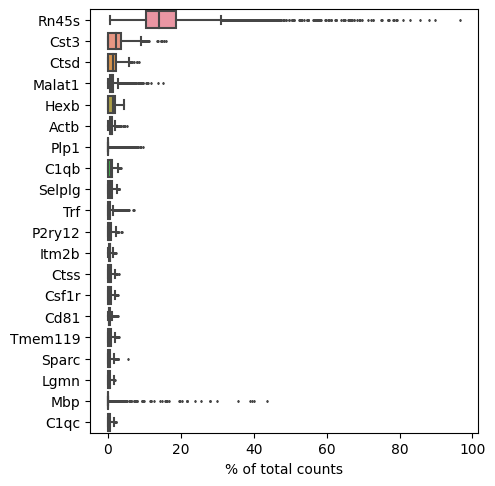

In [53]:
# genes with highest fraction of counts per cell
sc.pl.highest_expr_genes(adata, n_top=20, )

# Normalisation, logarithmization

Check if data is normalized:

In [54]:
adata.layers

Layers with keys: 

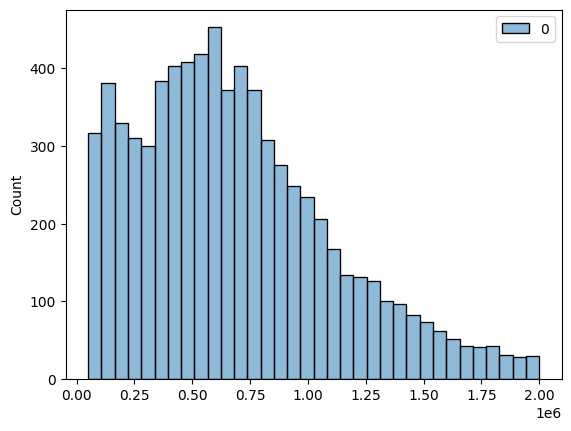

In [55]:
sb.histplot(adata.X.sum(1), kde=False)
plt.show()

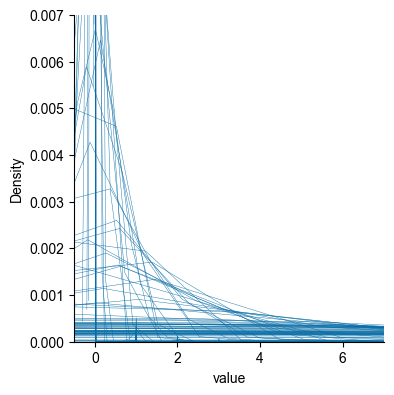

In [56]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
sns.set_theme(style='white')
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_20626/3567377032.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


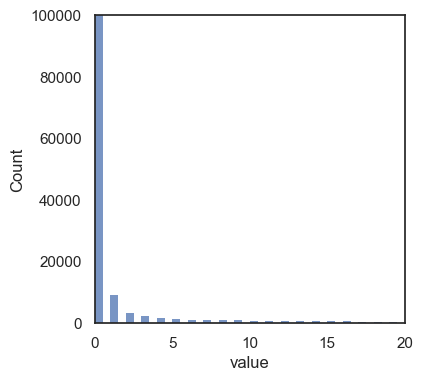

In [57]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [58]:
exp

0    1    2    3    4    5      6    7    8    9   ...     90   91  \
0      135.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...   37.0  0.0   
1     1221.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   
2      370.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...  148.0  0.0   
3        8.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...   70.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   
...      ...  ...  ...  ...  ...  ...    ...  ...  ...  ...  ...    ...  ...   
7360   177.0  0.0  0.0  0.0  0.0  0.0  202.0  0.0  0.0  0.0  ...    0.0  0.0   
7361     0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   
7362   207.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   
7363     0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   
7364   729.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...    0.0  0.0   

       92     93      94   95     96   97   98   99  
0     0.0    1.0   289.0  0.0  197.0  0.0  0.0  0.0  
1     0.0    0.0     0.0  0.0    0.0  0.0  0.0  0.0  
2     0.0    0.0     0.0  0.0    0.0  0.0  0.0  0.0  
3     0.0  159.0     0.0  0.0    0.0  0.0  0.0  0.0  
4     0.0    0.0     0.0  0.0    0.0  0.0  0.0  0.0  
...   ...    ...     ...  ...    ...  ...  ...  ...  
7360  0.0  123.0     0.0  0.0    0.0  0.0  0.0  0.0  
7361  0.0    0.0  1394.0  0.0    0.0  0.0  0.0  0.0  
7362  0.0   10.0     0.0  0.0  116.0  0.0  0.0  0.0  
7363  0.0    0.0     0.0  0.0    0.0  0.0  1.0  0.0  
7364  0.0   30.0     0.0  0.0    0.0  0.0  0.0  0.0  

[7365 rows x 100 columns]

In [59]:
adata.layers["counts"] = adata.X.copy()

In [60]:
sc.pp.normalize_total(adata, inplace=True)

normalizing counts per cell
    finished (0:00:00)


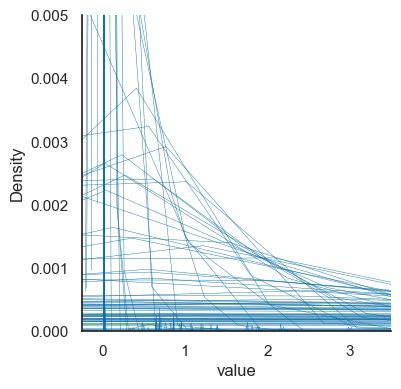

In [61]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_20626/1040332646.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


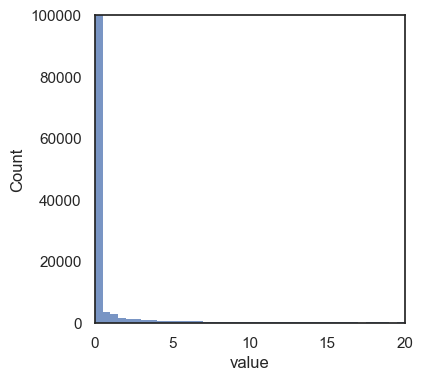

In [62]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [63]:
sc.pp.log1p(adata) # X = log(X + 1)

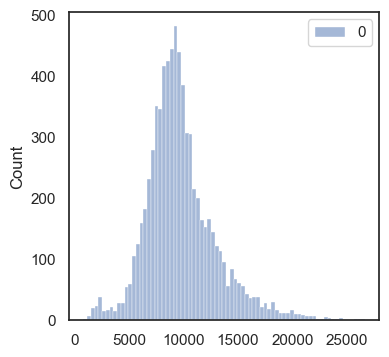

In [64]:
sb.histplot(adata.X.sum(1), kde=False)
plt.show()

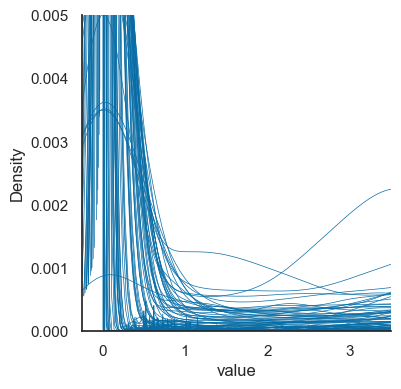

In [65]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_20626/3243830788.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


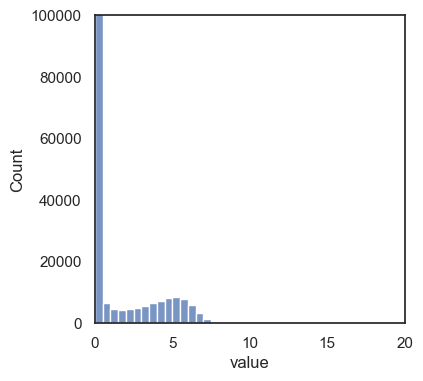

In [66]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [67]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


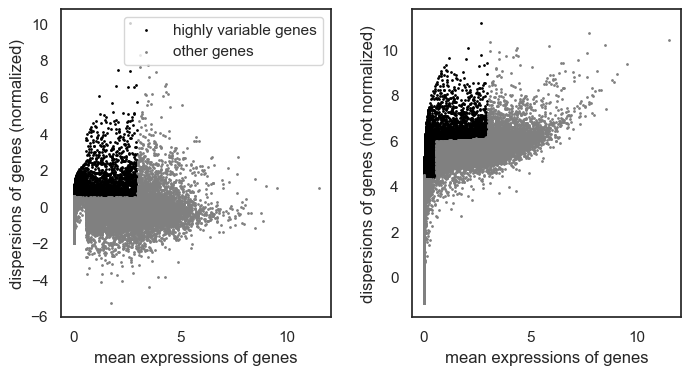

In [68]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [69]:
adata

AnnData object with n_obs × n_vars = 7365 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [70]:
adata.layers

Layers with keys: counts, normalized

# Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


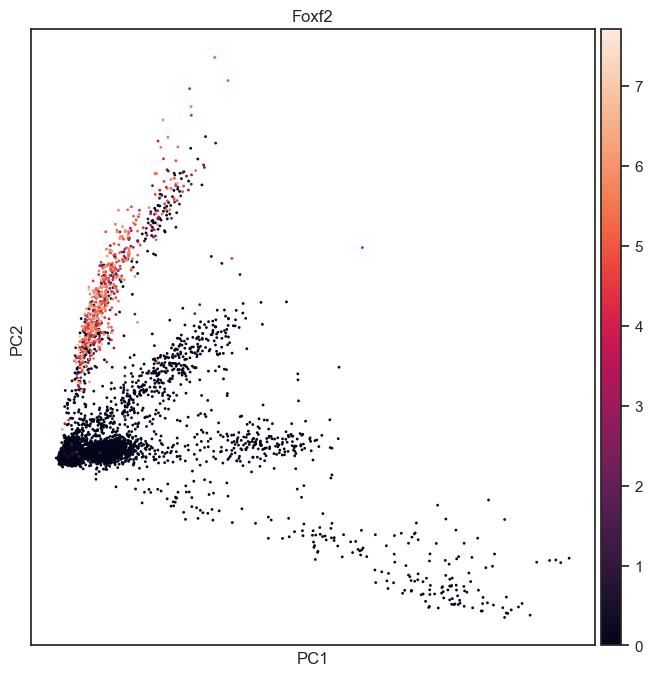

In [71]:
# Run PCA
with rc_context({'figure.figsize': (8, 8)}):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color='Foxf2')

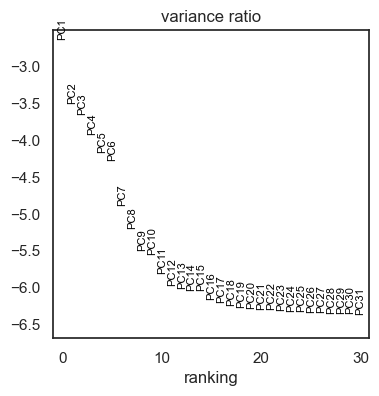

In [72]:
sc.pl.pca_variance_ratio(adata, log=True)

In [73]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [74]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [75]:
list(adata.obs.columns)

['batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type']

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


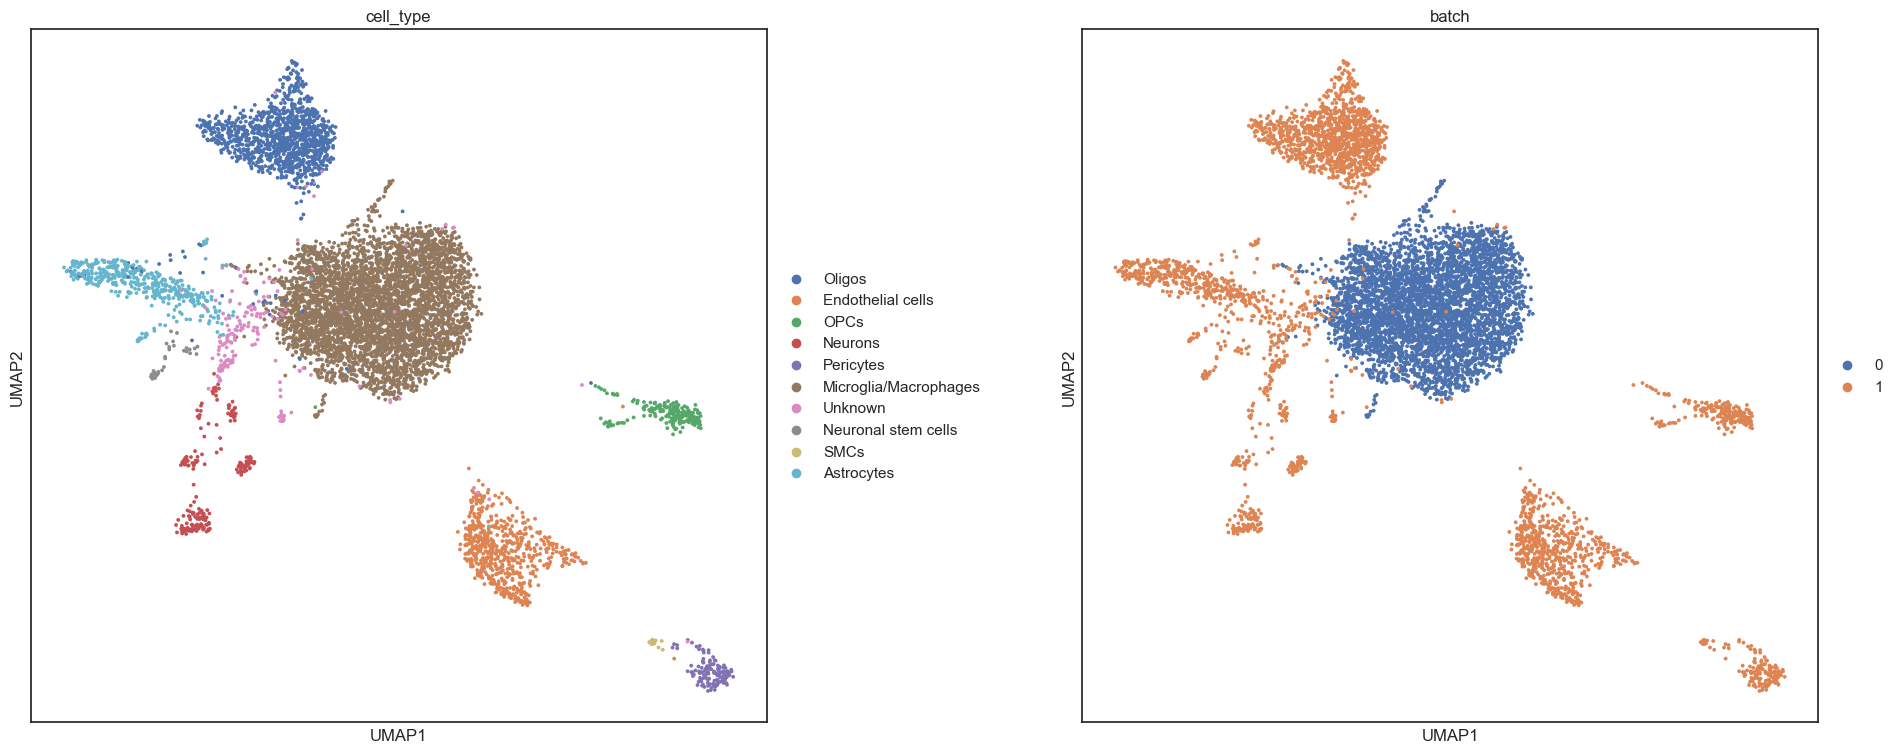

In [76]:
with rc_context({'figure.figsize': (9, 9)}):
    sc.pl.umap(adata, color=['cell_type', 'batch'], wspace=0.3, size=30)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


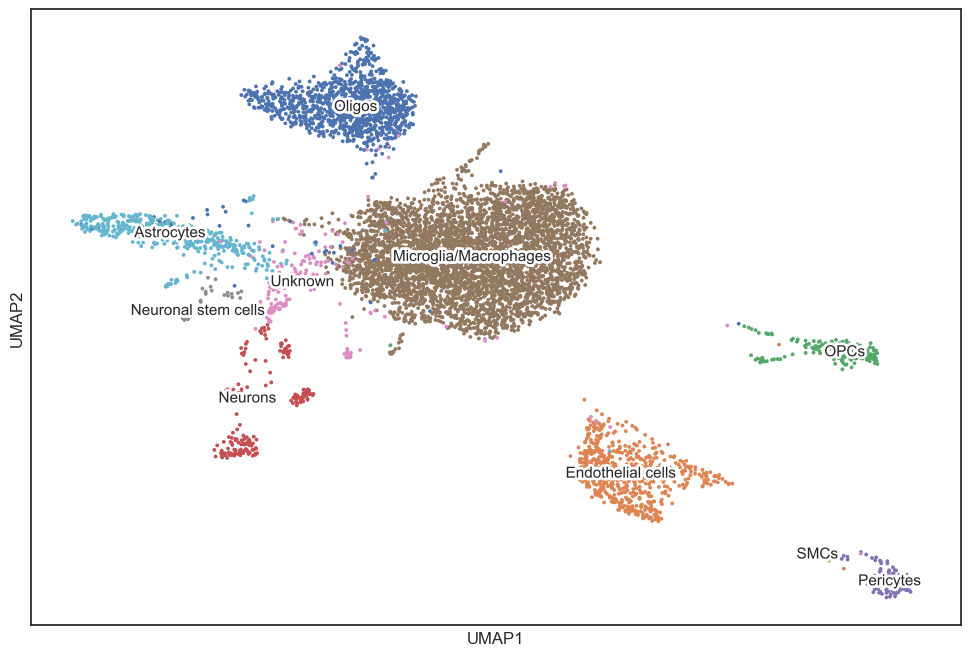

In [77]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=4, legend_fontsize=11, size=30)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


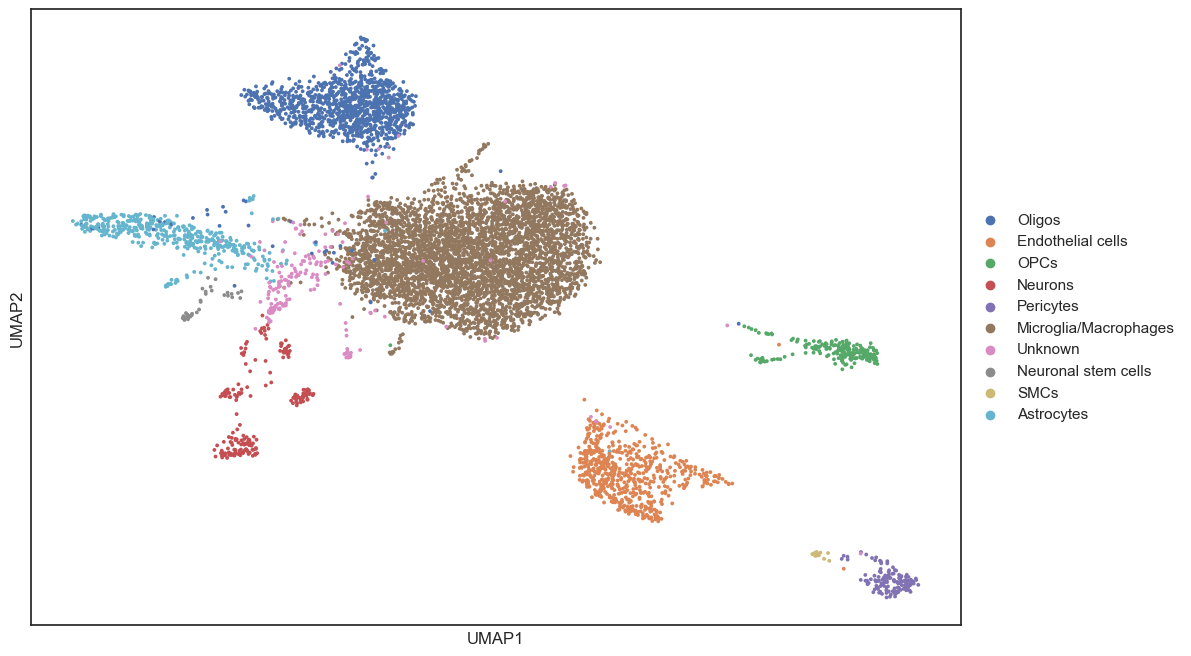

In [78]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], title='', legend_fontweight='normal', legend_fontoutline=4, legend_fontsize=11, size=30)

Note: SMC cluster is very small

In [79]:
adata.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
Pericytes                 132
Neuronal stem cells        36
SMCs                       14
Name: cell_type, dtype: int64

# Cell annotation

Verify annotation from authors

Manual marker gene selection

|Vascular     |EC         |Pericytes|SMCs   |Fibroblasts|Oligos|OPCs         |Ependymal|Neurons    |immature/migrating Neurons|Astrocytes|Microglia|Immune (broad/hematopoetic)|Macrophages     |Macrophages/Microglia|Monocytes|Mononcytes/B-cells|Granulocytes|B-cells|T/NK cells|
|---          |---        |---      |---    |---        |---   |---          |---      |---        |---   |---       |---      |---                        |---             |---|---|---|---|---|---|
|PDGFRA =CD140A|CLDN5      |VTN      |ACTA2  |DCN        |MBP   |CSPG4 =NG2    |PIFO     |RBFOX3 =NEUN|DCX   |AQP4      |AIF1     |PTPRC =CD45                 |CD14            |TREM2|CCR2|CD74|CD16/32|CD19|CD4|
|MCAM =CD146   |PECAM1 =CD31|PDGFRB   |MYOCD  |COL6A1     |ENPP2 |PDGFRA =CD140A|FOXJ1    |TUBB3      ||          |         |                           |ITGB2 =CD18 =CD11B||||ITGB2 =CD18 =CD11B||CD8A|
|FOXF2        |           |         |       |COL3A1     |      |             |DYNLRB2  |           ||          |         |                           |CD86            ||||CD15||CD8B|
|             |           |         |       |           |      |             |MEIG1    |           ||          |         |                           |ADGRE1 =F4/80    ||||||IL2RB|
||||||||||||||||||||IFNG|

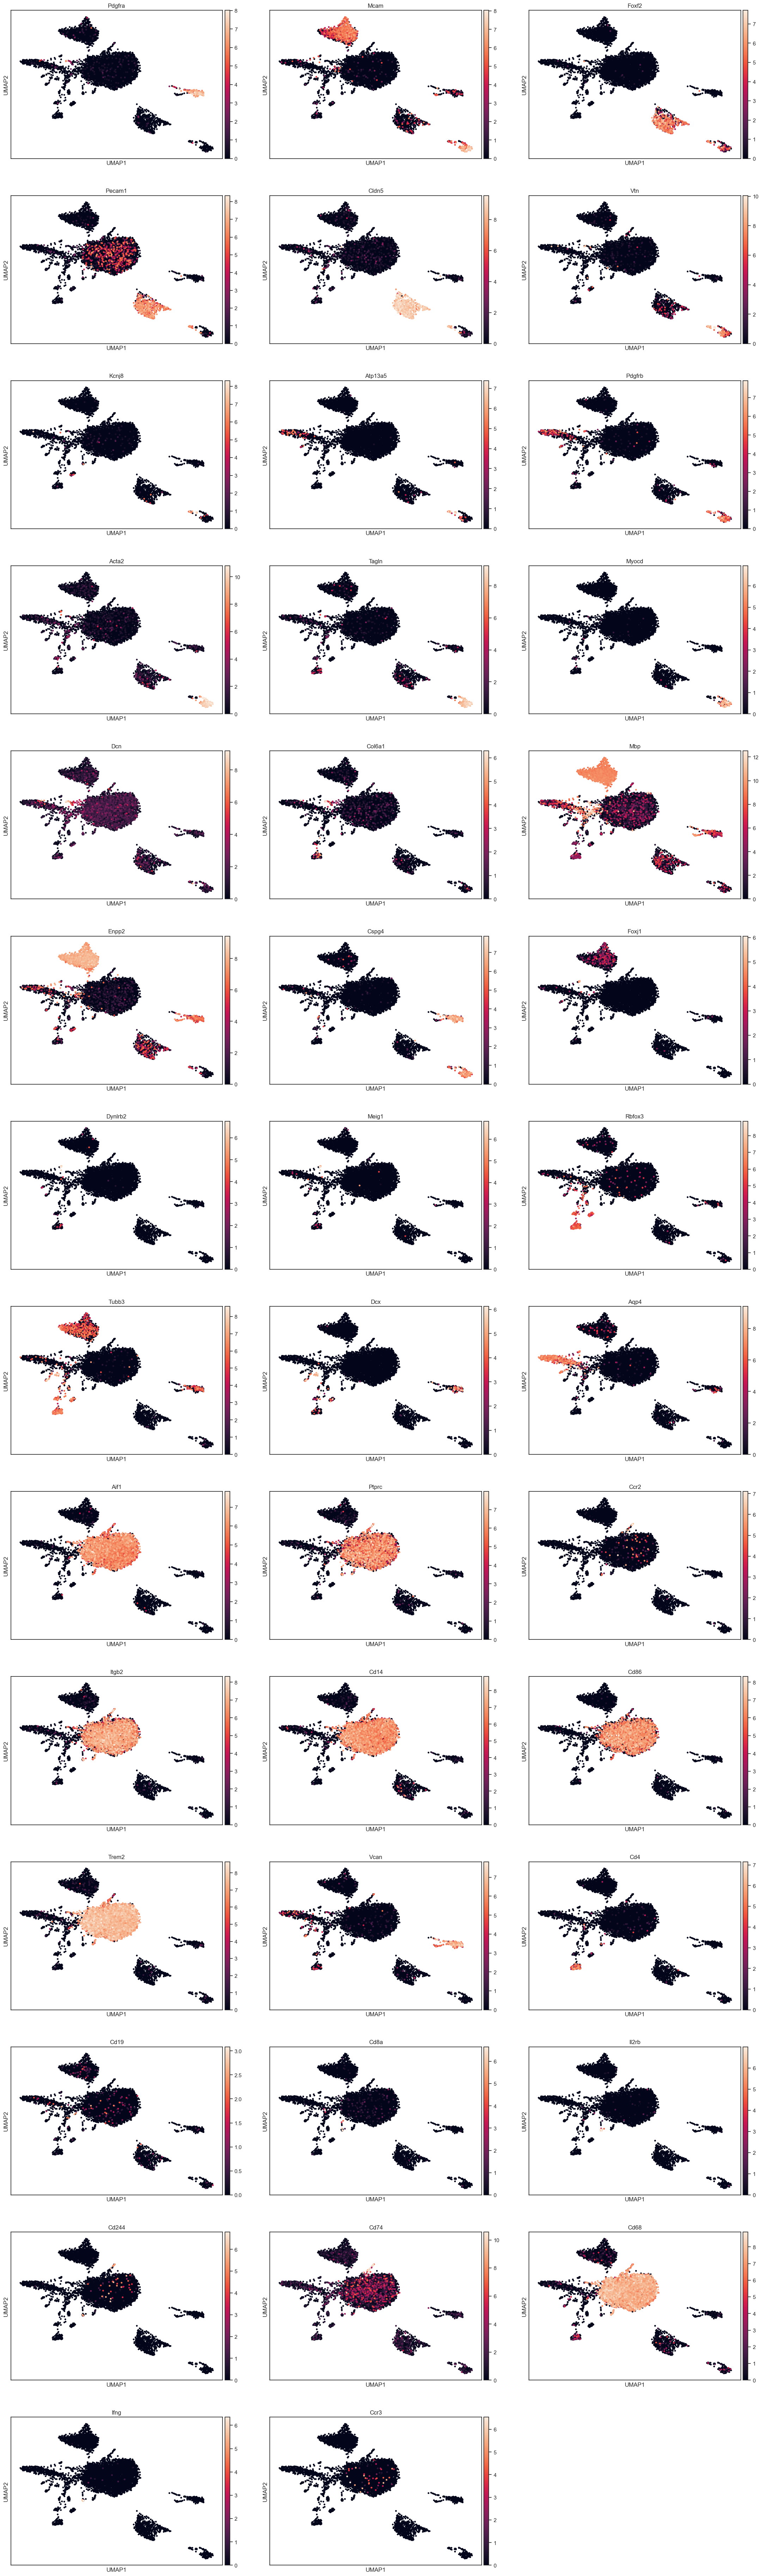

In [80]:
# plot marker genes
plt.rcParams['figure.figsize'] = [8, 6] # set plot sizes
marker_genes = ["Pdgfra", "Mcam","Foxf2", "Pecam1", "Cldn5","Vtn","Kcnj8","Atp13a5","Pdgfrb","Acta2","Tagln","Myocd","Dcn", "Col6a1", "Mbp","Enpp2","Cspg4","Pifo","Foxj1","Dynlrb2","Meig1","Rbfox3","Tubb3","Dcx","Aqp4", "Aif1", "Ptprc", "Ccr2","Adgre1","Itgb2","Cd14","Cd86","Trem2","Vcan","Cd4","Cd19", "Cd8a","Il2rb","Cd244", "Cd74","Cd68","Ifng","Ptgdr2","Ccr3"]
marker_genes=[x for x in marker_genes if x in list(adata.var_names)] # remove those not in adata.var_names
sc.pl.umap(adata, ncols=3, color=marker_genes, size=50)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


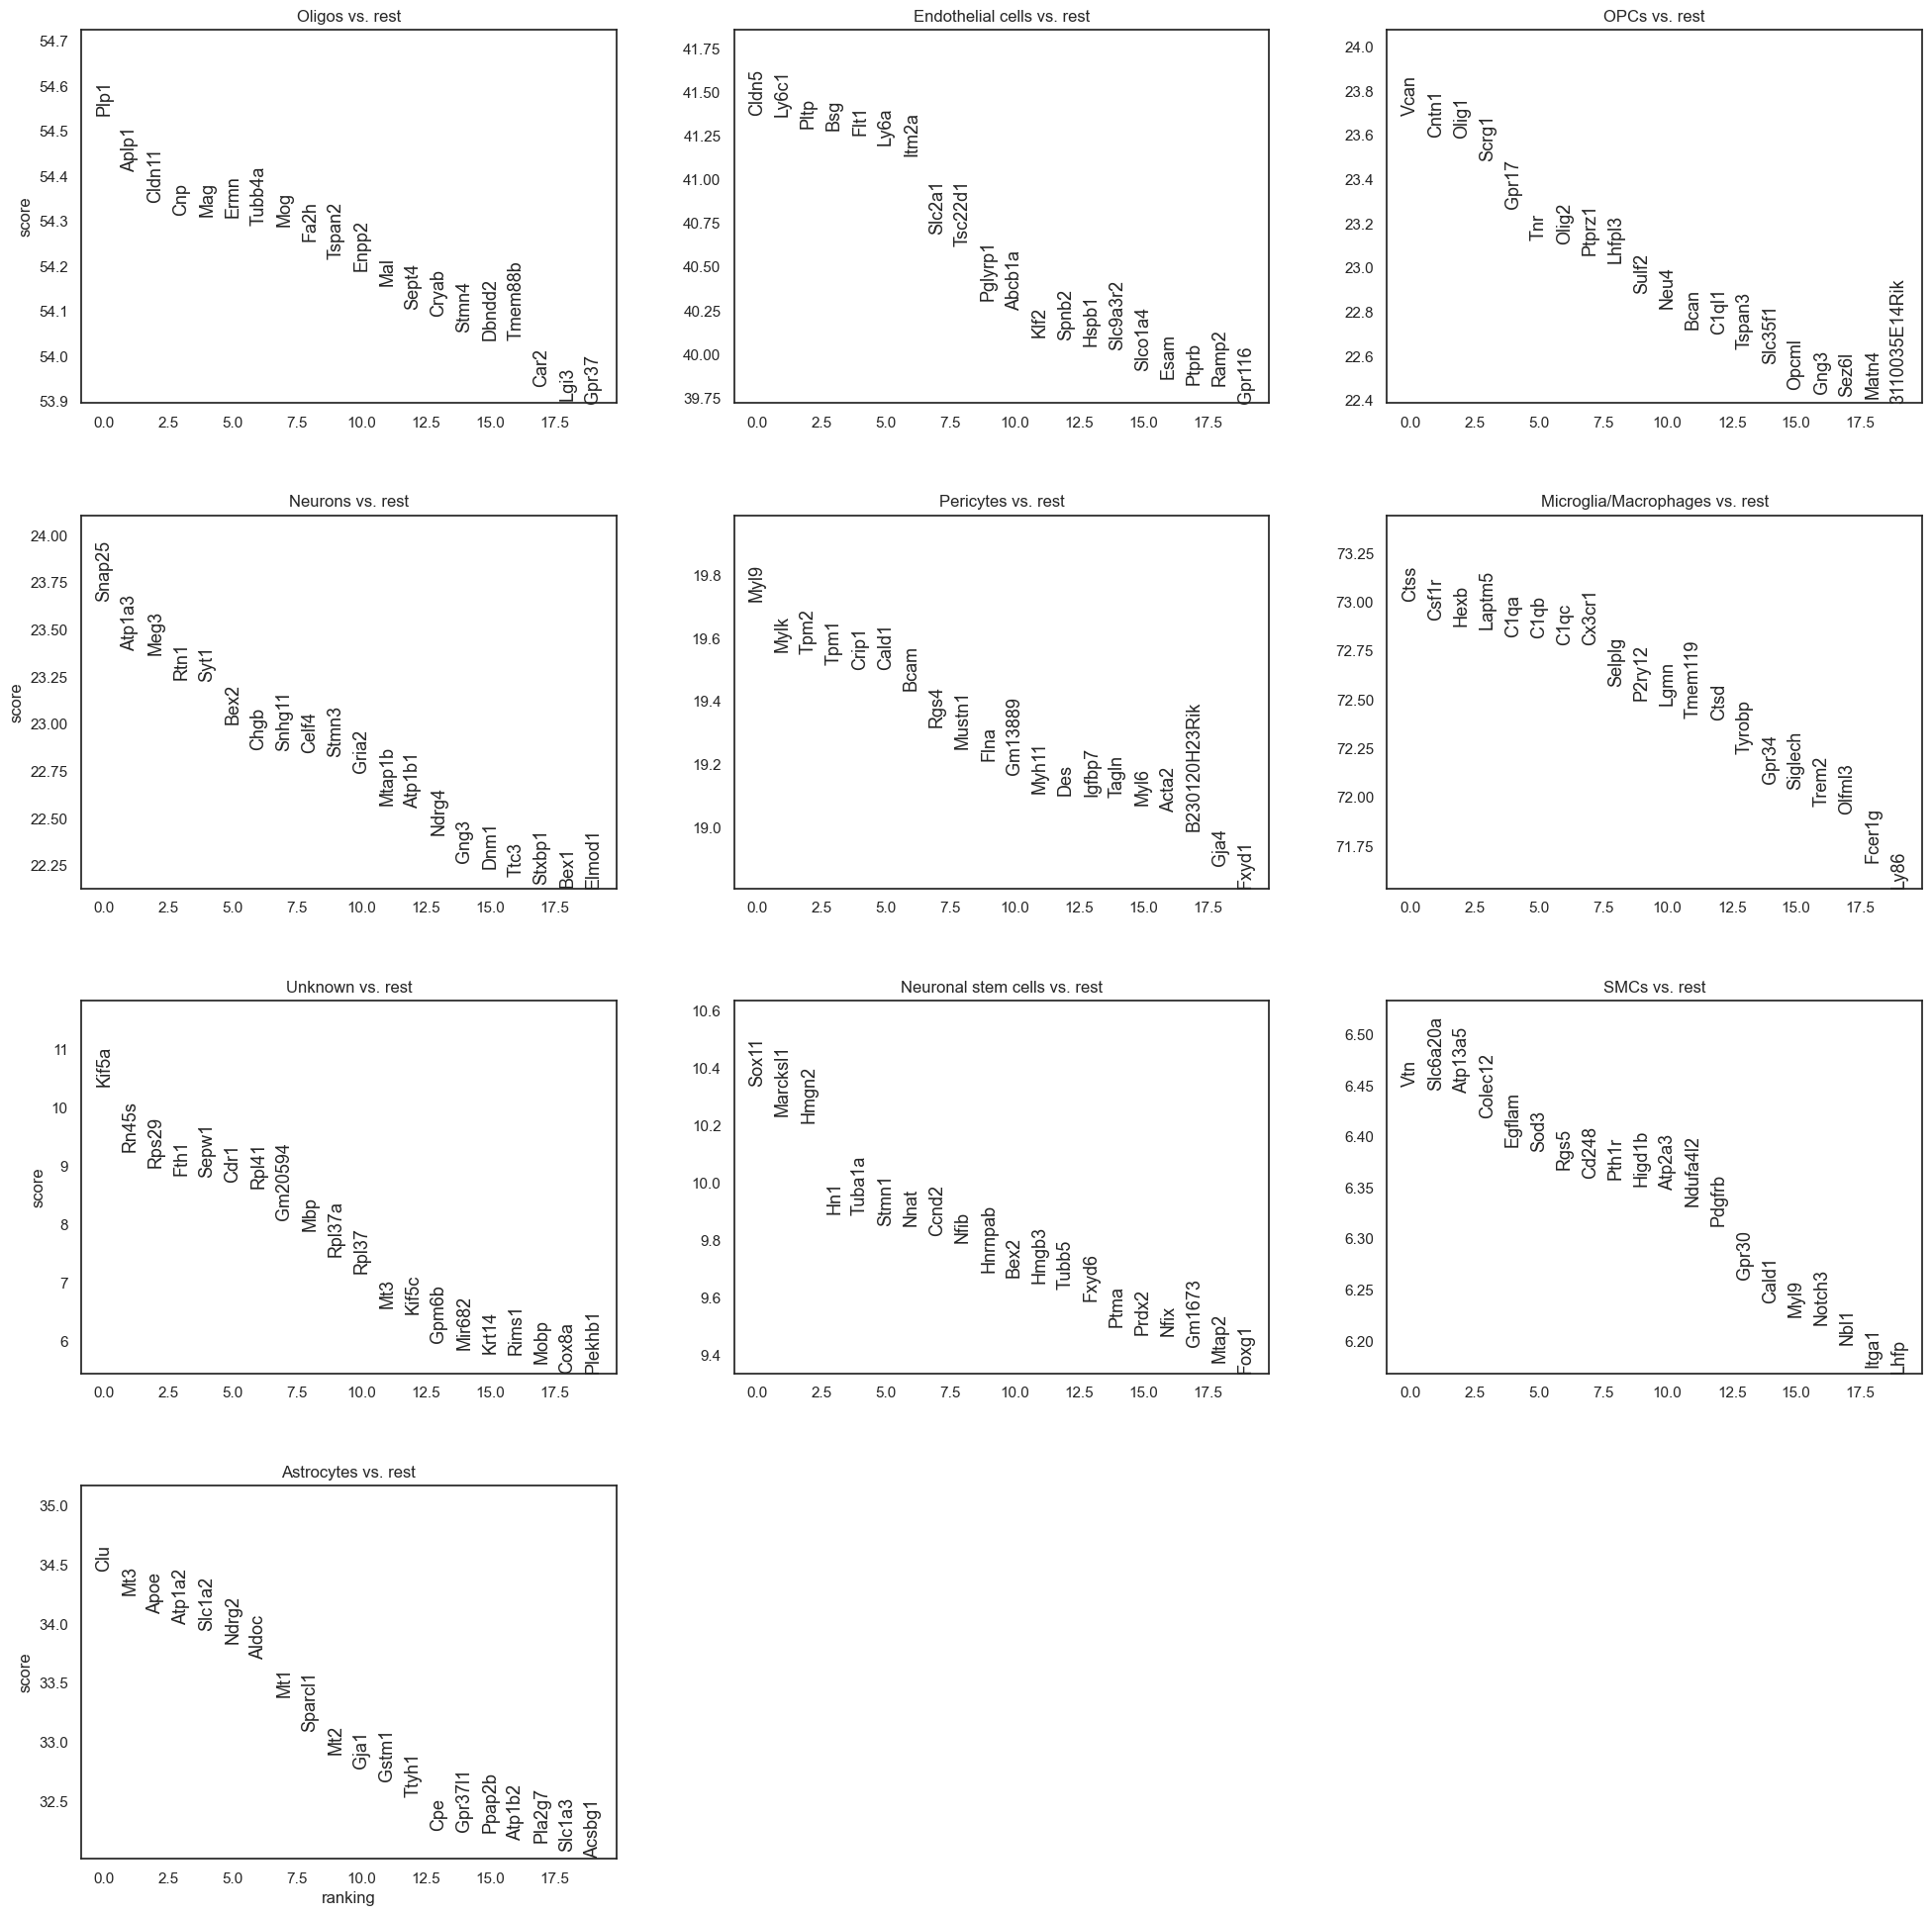

In [81]:
# Run DE test for annotation (Wilcoxon)
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, fontsize=13, key='wilcoxon')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


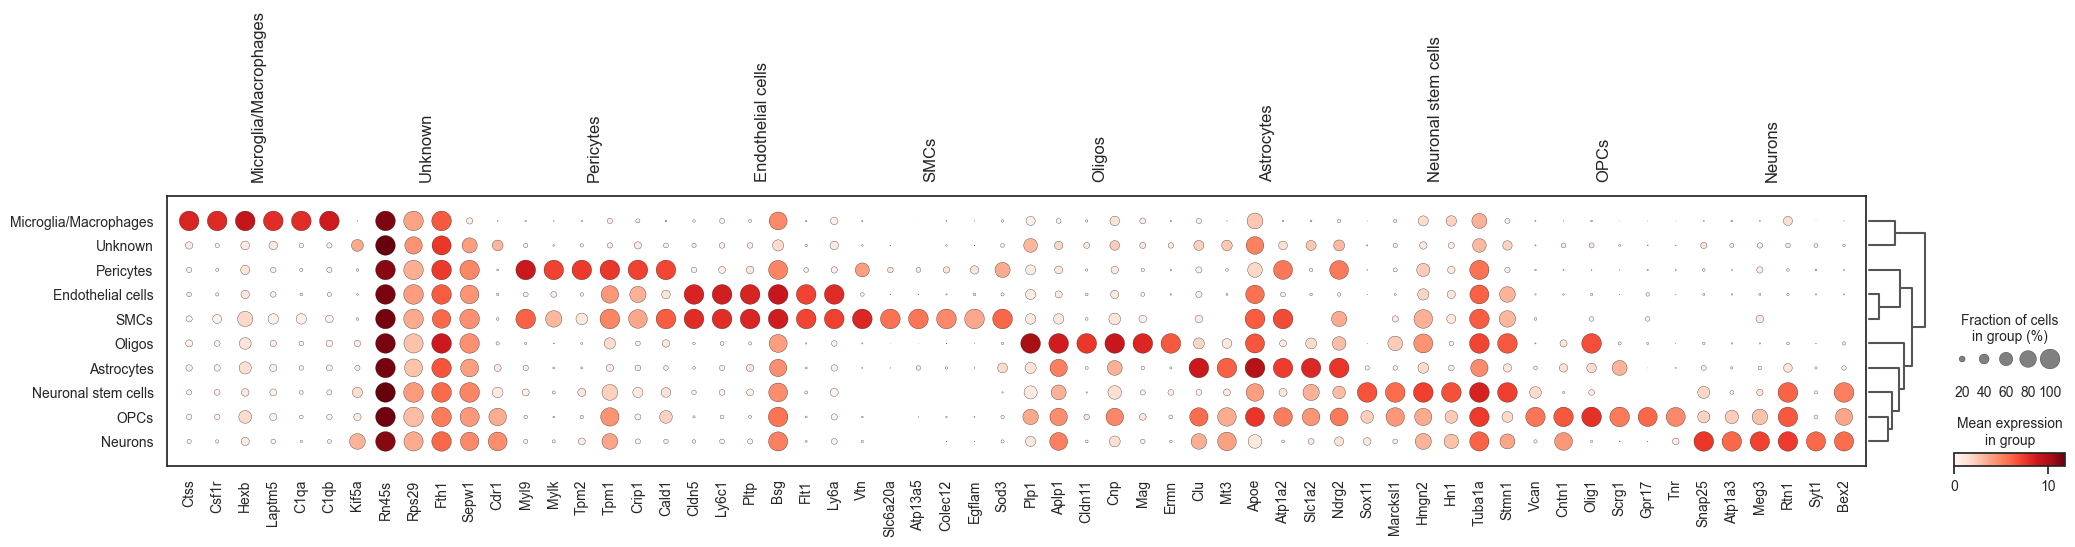

In [82]:
# Dotplot
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="wilcoxon", groupby="cell_type");

Own note: The clusters SMCs and Pericytes seem to be wrongly switched. The pericyte markers Vtn, Atp13a5, Pdgfrb are among top SMC hits. Conversely, SMC marker genes are constituting the top hits from the pericyte cluster. Therefore, switch annotations:


In [83]:
adata_tamu = adata
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'SMCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'Pericytes'
adata = adata_tamu
del adata_tamu

In [84]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

In [85]:
adata.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
SMCs                      132
Neuronal stem cells        36
Pericytes                  14
Name: cell_type, dtype: int64

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


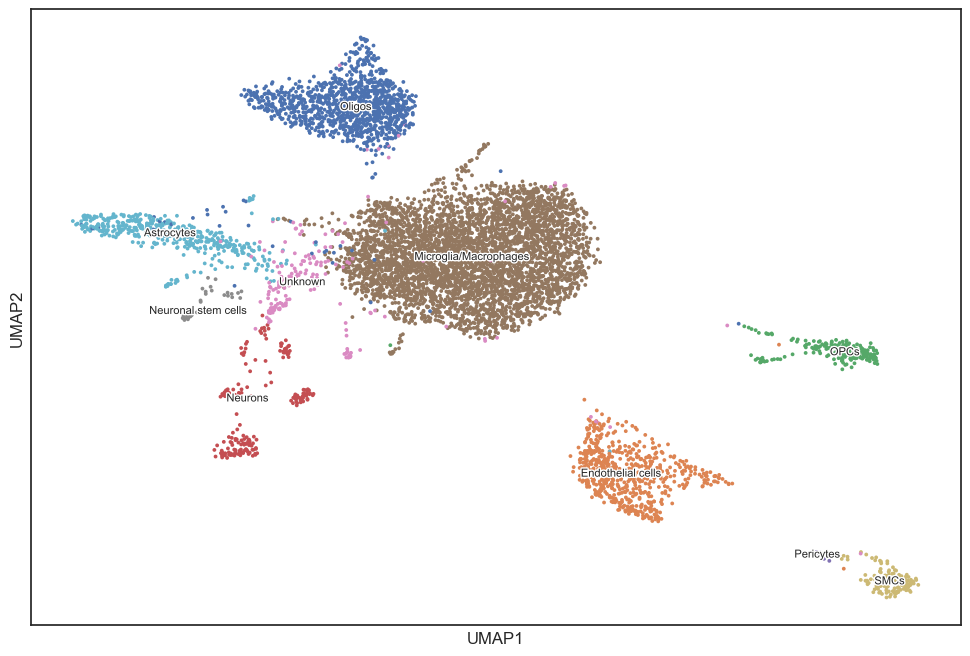

In [86]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=8, size=30)

In [87]:
# exclude clusters with <50 cells
cluster_counts = adata.obs['cell_type'].value_counts()
cluster_counts

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
SMCs                      132
Neuronal stem cells        36
Pericytes                  14
Name: cell_type, dtype: int64

In [88]:
adata = adata[adata.obs['cell_type'].isin(cluster_counts[cluster_counts>49].index)]

In [89]:
adata.obs['clusters'] = adata.obs['cell_type']

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_20626/136208837.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['clusters'] = adata.obs['cell_type']


# Focus on: Foxf2

In [90]:
gene="Foxf2"

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


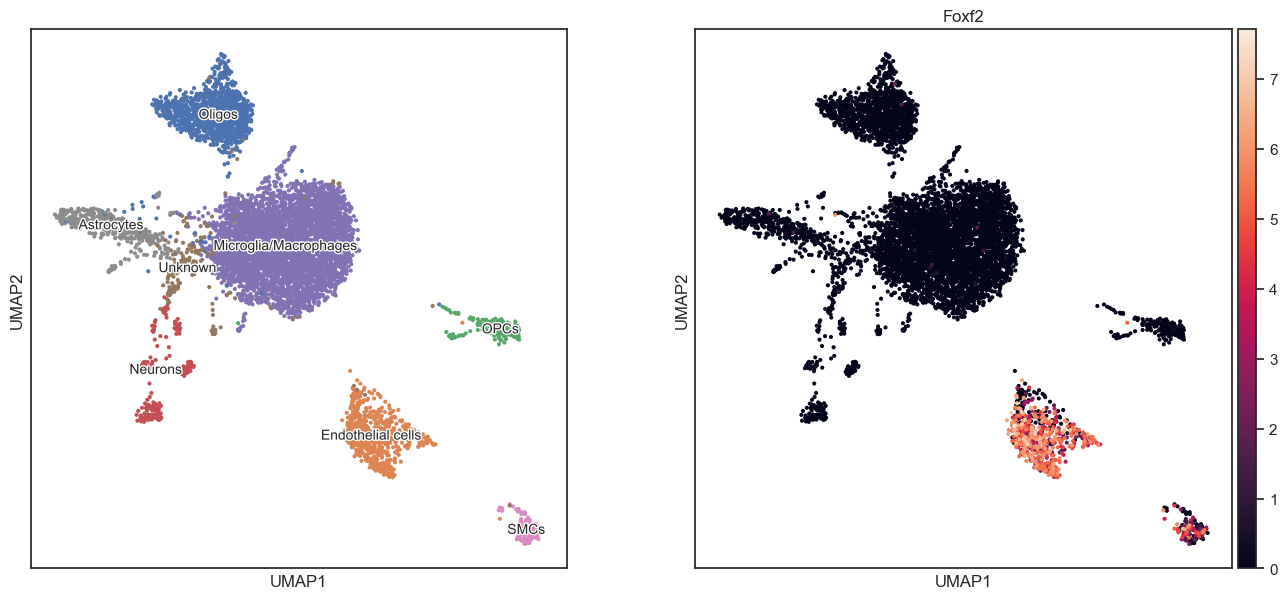

In [91]:
with rc_context({'figure.figsize': (7,7)}):
    sc.pl.umap(adata, color=['clusters',gene], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=10, size=35, layer="normalized")

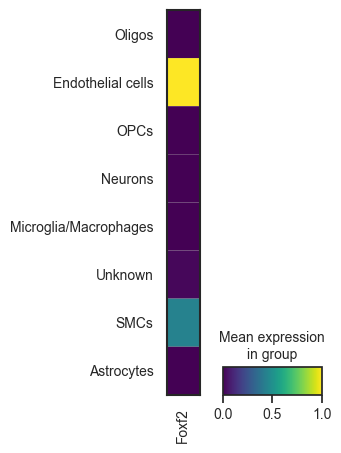

In [92]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [93]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000606
Endothelial cells             1.000000
OPCs                          0.000000
Neurons                       0.000495
Microglia/Macrophages         0.000184
Unknown                       0.019235
SMCs                          0.438674
Astrocytes                    0.001862

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


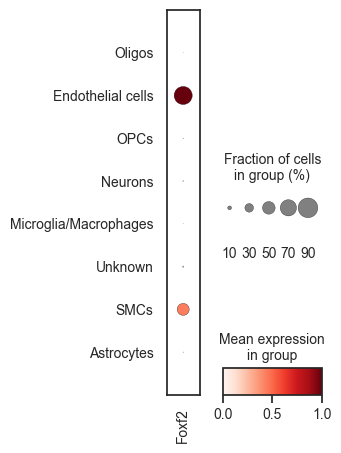

In [94]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [95]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.001686
Endothelial cells               0.806400
OPCs                            0.004950
Neurons                         0.010204
Microglia/Macrophages           0.002291
Unknown                         0.022727
SMCs                            0.469697
Astrocytes                      0.004619

In [97]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "TabulaMuris2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
#foxf2.index.name = "clusters"
foxf2

mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.000606           0.001686  Foxf2   
Endothelial cells             1.000000           0.806400  Foxf2   
OPCs                          0.000000           0.004950  Foxf2   
Neurons                       0.000495           0.010204  Foxf2   
Microglia/Macrophages         0.000184           0.002291  Foxf2   
Unknown                       0.019235           0.022727  Foxf2   
SMCs                          0.438674           0.469697  Foxf2   
Astrocytes                    0.001862           0.004619  Foxf2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [90]:
# export
name='TabulaMuris2018'

In [91]:
# Win + Linux
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [98]:
gene="Foxo1"

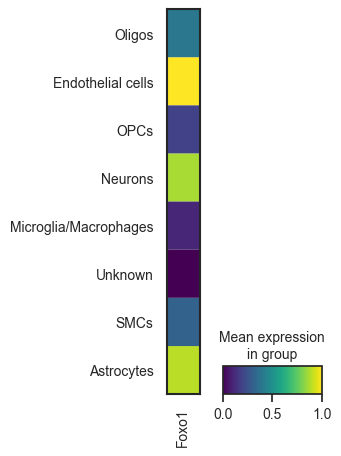

In [101]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.396136
Endothelial cells             1.000000
OPCs                          0.198107
Neurons                       0.871032
Microglia/Macrophages         0.105590
Unknown                       0.000000
SMCs                          0.310062
Astrocytes                    0.894739

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


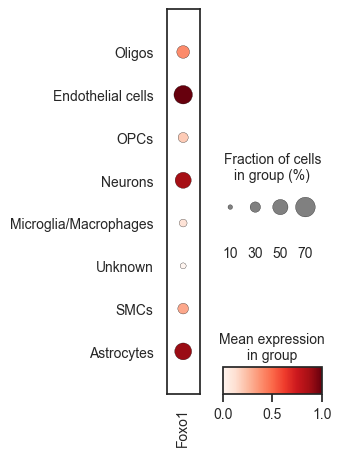

In [103]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [104]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.392074
Endothelial cells               0.646400
OPCs                            0.287129
Neurons                         0.535714
Microglia/Macrophages           0.202520
Unknown                         0.142045
SMCs                            0.310606
Astrocytes                      0.572748

In [105]:
foxo1 = pd.concat([ex, fc], axis=1)
foxo1['gene'] = gene
foxo1['source'] = "TabulaMuris2018"
foxo1['organism'] = "Mouse"
foxo1['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxo1.index)
foxo1

mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.396136           0.392074  Foxo1   
Endothelial cells             1.000000           0.646400  Foxo1   
OPCs                          0.198107           0.287129  Foxo1   
Neurons                       0.871032           0.535714  Foxo1   
Microglia/Macrophages         0.105590           0.202520  Foxo1   
Unknown                       0.000000           0.142045  Foxo1   
SMCs                          0.310062           0.310606  Foxo1   
Astrocytes                    0.894739           0.572748  Foxo1   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [98]:
# export
name='TabulaMuris2018'

In [99]:
# Win
foxo1.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Tek = Tie2

In [100]:
gene="Tek"

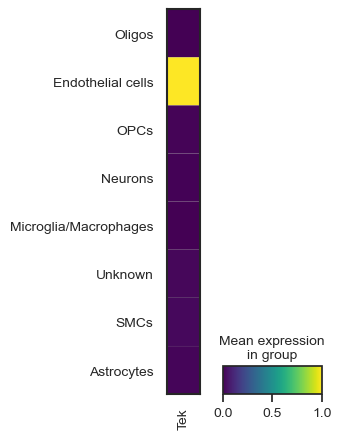

In [101]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.000000
Endothelial cells             1.000000
OPCs                          0.009527
Neurons                       0.007500
Microglia/Macrophages         0.000052
Unknown                       0.015907
SMCs                          0.021271
Astrocytes                    0.014739

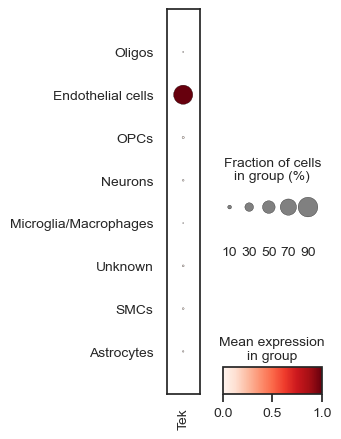

In [103]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [104]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.018550
Endothelial cells               0.872000
OPCs                            0.049505
Neurons                         0.035714
Microglia/Macrophages           0.015808
Unknown                         0.039773
SMCs                            0.037879
Astrocytes                      0.030023

In [105]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells gene  \
cell_type                                                        
Oligos                        0.000000           0.018550  Tek   
Endothelial cells             1.000000           0.872000  Tek   
OPCs                          0.009527           0.049505  Tek   
Neurons                       0.007500           0.035714  Tek   
Microglia/Macrophages         0.000052           0.015808  Tek   
Unknown                       0.015907           0.039773  Tek   
SMCs                          0.021271           0.037879  Tek   
Astrocytes                    0.014739           0.030023  Tek   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [106]:
# export
name='TabulaMuris2018'

In [107]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Nos3 = eNOS

In [108]:
gene="Nos3"

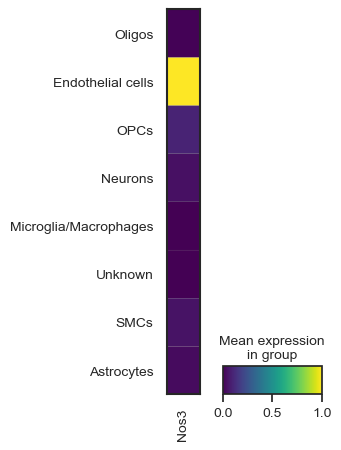

In [109]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.006943
Endothelial cells             1.000000
OPCs                          0.096897
Neurons                       0.042359
Microglia/Macrophages         0.002704
Unknown                       0.000000
SMCs                          0.048498
Astrocytes                    0.029830

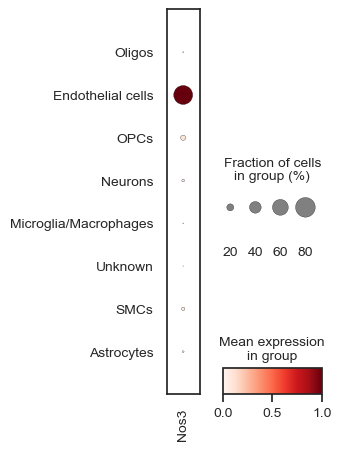

In [111]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [112]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.013491
Endothelial cells               0.761600
OPCs                            0.133663
Neurons                         0.056122
Microglia/Macrophages           0.008935
Unknown                         0.005682
SMCs                            0.075758
Astrocytes                      0.032333

In [113]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
cell_type                                                         
Oligos                        0.006943           0.013491  Nos3   
Endothelial cells             1.000000           0.761600  Nos3   
OPCs                          0.096897           0.133663  Nos3   
Neurons                       0.042359           0.056122  Nos3   
Microglia/Macrophages         0.002704           0.008935  Nos3   
Unknown                       0.000000           0.005682  Nos3   
SMCs                          0.048498           0.075758  Nos3   
Astrocytes                    0.029830           0.032333  Nos3   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [114]:
# export
name='TabulaMuris2018'

In [115]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Htra1

In [84]:
gene="Htra1"

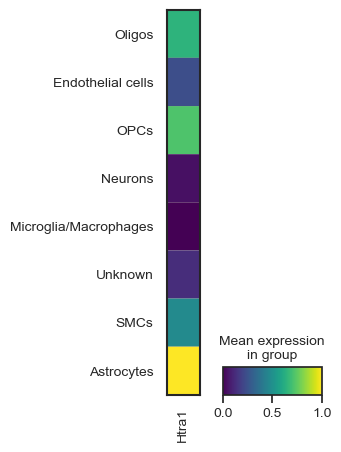

In [85]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [86]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.646845
Endothelial cells             0.237880
OPCs                          0.722030
Neurons                       0.042713
Microglia/Macrophages         0.000000
Unknown                       0.128870
SMCs                          0.476055
Astrocytes                    1.000000

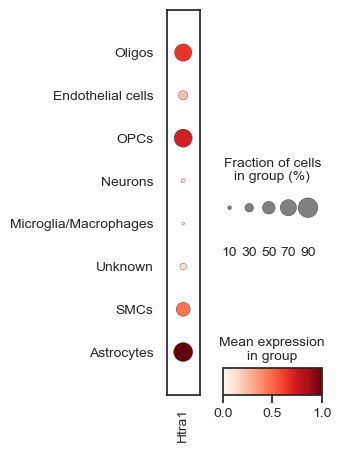

In [87]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [88]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.756324
Endothelial cells               0.332800
OPCs                            0.801980
Neurons                         0.107143
Microglia/Macrophages           0.058190
Unknown                         0.210227
SMCs                            0.568182
Astrocytes                      0.856813

In [89]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells   gene  \
cell_type                                                          
Oligos                        0.646845           0.756324  Htra1   
Endothelial cells             0.237880           0.332800  Htra1   
OPCs                          0.722030           0.801980  Htra1   
Neurons                       0.042713           0.107143  Htra1   
Microglia/Macrophages         0.000000           0.058190  Htra1   
Unknown                       0.128870           0.210227  Htra1   
SMCs                          0.476055           0.568182  Htra1   
Astrocytes                    1.000000           0.856813  Htra1   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [90]:
# export
name='TabulaMuris2018'

In [91]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Egfl8

In [92]:
gene="Egfl8"

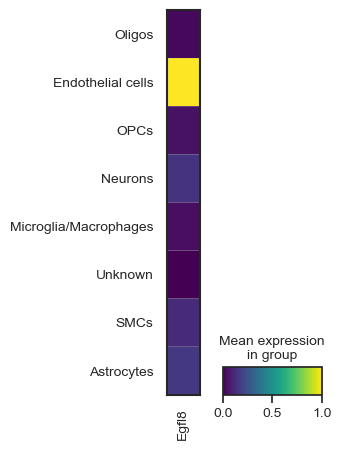

In [93]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [94]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.019646
Endothelial cells             1.000000
OPCs                          0.044002
Neurons                       0.145450
Microglia/Macrophages         0.035736
Unknown                       0.000000
SMCs                          0.119710
Astrocytes                    0.162435

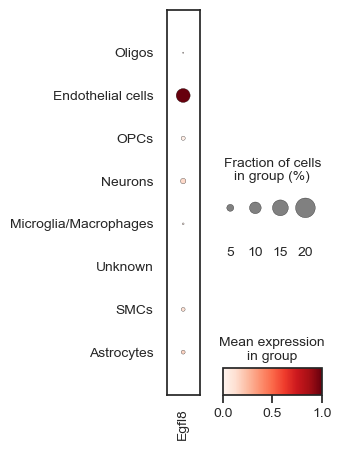

In [95]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [96]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.005059
Endothelial cells               0.126400
OPCs                            0.024752
Neurons                         0.035714
Microglia/Macrophages           0.008247
Unknown                         0.000000
SMCs                            0.022727
Astrocytes                      0.023095

In [97]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells   gene  \
cell_type                                                          
Oligos                        0.019646           0.005059  Egfl8   
Endothelial cells             1.000000           0.126400  Egfl8   
OPCs                          0.044002           0.024752  Egfl8   
Neurons                       0.145450           0.035714  Egfl8   
Microglia/Macrophages         0.035736           0.008247  Egfl8   
Unknown                       0.000000           0.000000  Egfl8   
SMCs                          0.119710           0.022727  Egfl8   
Astrocytes                    0.162435           0.023095  Egfl8   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [98]:
# export
name='TabulaMuris2018'

In [99]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Flt1

In [106]:
gene="Flt1"

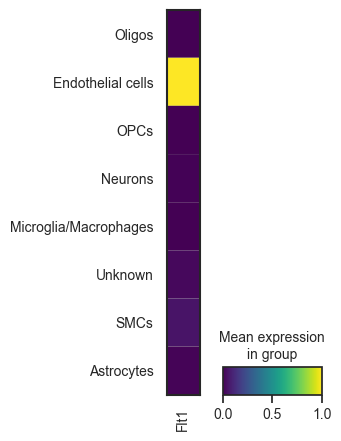

In [107]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [108]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000000
Endothelial cells             1.000000
OPCs                          0.003870
Neurons                       0.007380
Microglia/Macrophages         0.000337
Unknown                       0.019751
SMCs                          0.052467
Astrocytes                    0.010907

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


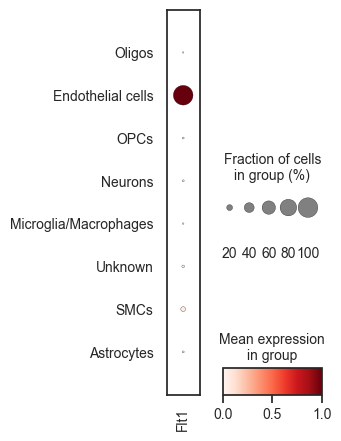

In [109]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [110]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.028668
Endothelial cells               0.998400
OPCs                            0.044554
Neurons                         0.045918
Microglia/Macrophages           0.032532
Unknown                         0.068182
SMCs                            0.151515
Astrocytes                      0.046189

In [111]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
clusters                                                          
Oligos                        0.000000           0.028668  Flt1   
Endothelial cells             1.000000           0.998400  Flt1   
OPCs                          0.003870           0.044554  Flt1   
Neurons                       0.007380           0.045918  Flt1   
Microglia/Macrophages         0.000337           0.032532  Flt1   
Unknown                       0.019751           0.068182  Flt1   
SMCs                          0.052467           0.151515  Flt1   
Astrocytes                    0.010907           0.046189  Flt1   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [112]:
# export
name='TabulaMuris2018'

In [113]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Kdr

In [114]:
gene="Kdr"

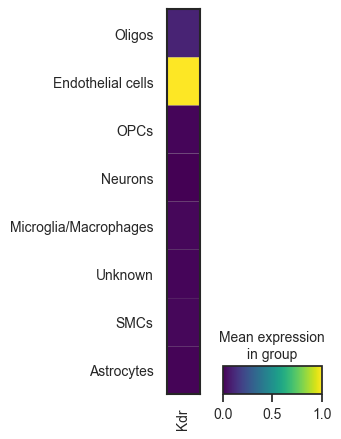

In [115]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [116]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.094983
Endothelial cells             1.000000
OPCs                          0.011960
Neurons                       0.000000
Microglia/Macrophages         0.018577
Unknown                       0.014566
SMCs                          0.019391
Astrocytes                    0.008581

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


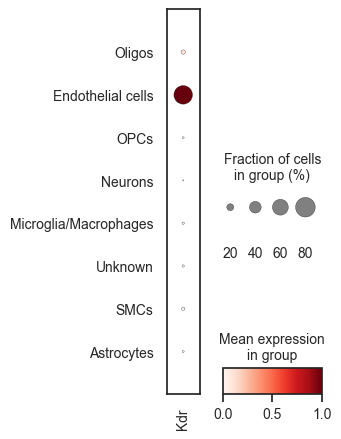

In [117]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [118]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.106239
Endothelial cells               0.740800
OPCs                            0.034653
Neurons                         0.020408
Microglia/Macrophages           0.048568
Unknown                         0.045455
SMCs                            0.075758
Astrocytes                      0.036952

In [119]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells gene  \
clusters                                                         
Oligos                        0.094983           0.106239  Kdr   
Endothelial cells             1.000000           0.740800  Kdr   
OPCs                          0.011960           0.034653  Kdr   
Neurons                       0.000000           0.020408  Kdr   
Microglia/Macrophages         0.018577           0.048568  Kdr   
Unknown                       0.014566           0.045455  Kdr   
SMCs                          0.019391           0.075758  Kdr   
Astrocytes                    0.008581           0.036952  Kdr   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [120]:
# export
name='TabulaMuris2018'

In [121]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Nrp1

In [122]:
gene="Nrp1"

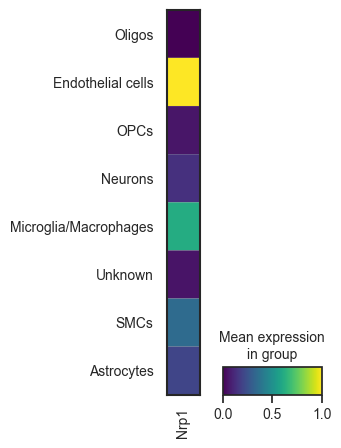

In [123]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [124]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000000
Endothelial cells             1.000000
OPCs                          0.056844
Neurons                       0.139041
Microglia/Macrophages         0.615913
Unknown                       0.050814
SMCs                          0.347256
Astrocytes                    0.205039

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


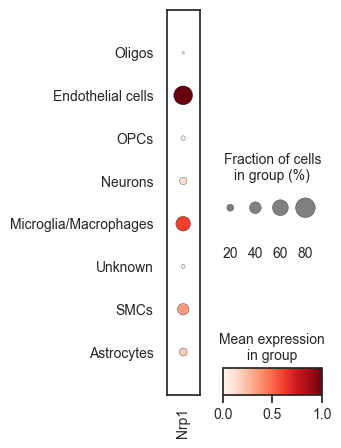

In [125]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [126]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.044688
Endothelial cells               0.758400
OPCs                            0.113861
Neurons                         0.224490
Microglia/Macrophages           0.541352
Unknown                         0.090909
SMCs                            0.393939
Astrocytes                      0.240185

In [127]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
clusters                                                          
Oligos                        0.000000           0.044688  Nrp1   
Endothelial cells             1.000000           0.758400  Nrp1   
OPCs                          0.056844           0.113861  Nrp1   
Neurons                       0.139041           0.224490  Nrp1   
Microglia/Macrophages         0.615913           0.541352  Nrp1   
Unknown                       0.050814           0.090909  Nrp1   
SMCs                          0.347256           0.393939  Nrp1   
Astrocytes                    0.205039           0.240185  Nrp1   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [128]:
# export
name='TabulaMuris2018'

In [129]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Nrp2

In [130]:
gene="Nrp2"

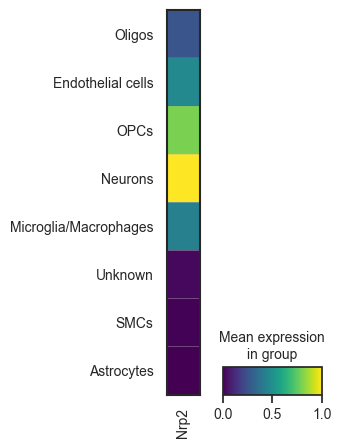

In [131]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [132]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.258782
Endothelial cells             0.470521
OPCs                          0.797830
Neurons                       1.000000
Microglia/Macrophages         0.431330
Unknown                       0.021474
SMCs                          0.006879
Astrocytes                    0.000000

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


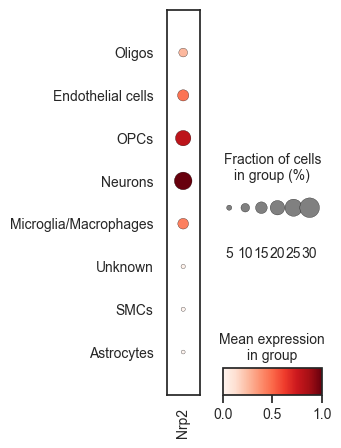

In [133]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [134]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.102024
Endothelial cells               0.142400
OPCs                            0.217822
Neurons                         0.260204
Microglia/Macrophages           0.133792
Unknown                         0.039773
SMCs                            0.037879
Astrocytes                      0.034642

In [135]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
clusters                                                          
Oligos                        0.258782           0.102024  Nrp2   
Endothelial cells             0.470521           0.142400  Nrp2   
OPCs                          0.797830           0.217822  Nrp2   
Neurons                       1.000000           0.260204  Nrp2   
Microglia/Macrophages         0.431330           0.133792  Nrp2   
Unknown                       0.021474           0.039773  Nrp2   
SMCs                          0.006879           0.037879  Nrp2   
Astrocytes                    0.000000           0.034642  Nrp2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [136]:
# export
name='TabulaMuris2018'

In [137]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Efnb2

In [138]:
gene="Efnb2"

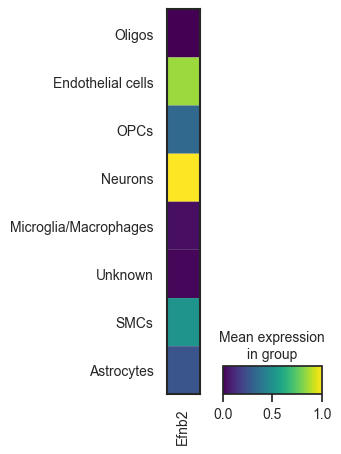

In [139]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [141]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000000
Endothelial cells             0.851007
OPCs                          0.335515
Neurons                       1.000000
Microglia/Macrophages         0.038052
Unknown                       0.019378
SMCs                          0.516269
Astrocytes                    0.259280

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


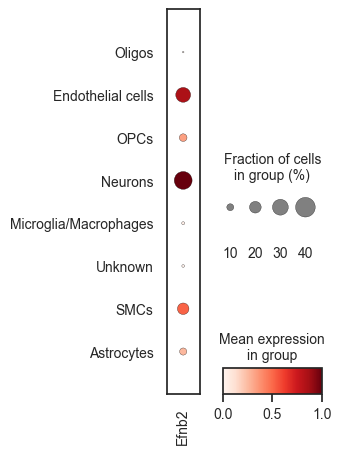

In [142]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [143]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.014334
Endothelial cells               0.275200
OPCs                            0.113861
Neurons                         0.352041
Microglia/Macrophages           0.032532
Unknown                         0.028409
SMCs                            0.196970
Astrocytes                      0.103926

In [144]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.000000           0.014334  Efnb2   
Endothelial cells             0.851007           0.275200  Efnb2   
OPCs                          0.335515           0.113861  Efnb2   
Neurons                       1.000000           0.352041  Efnb2   
Microglia/Macrophages         0.038052           0.032532  Efnb2   
Unknown                       0.019378           0.028409  Efnb2   
SMCs                          0.516269           0.196970  Efnb2   
Astrocytes                    0.259280           0.103926  Efnb2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [145]:
# export
name='TabulaMuris2018'

In [146]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Itgb1

In [147]:
gene="Itgb1"

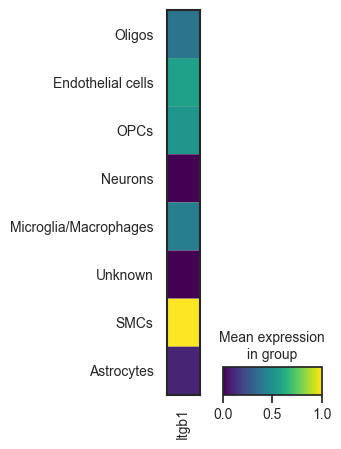

In [148]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [149]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.381315
Endothelial cells             0.563962
OPCs                          0.525735
Neurons                       0.001988
Microglia/Macrophages         0.424303
Unknown                       0.000000
SMCs                          1.000000
Astrocytes                    0.099876

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


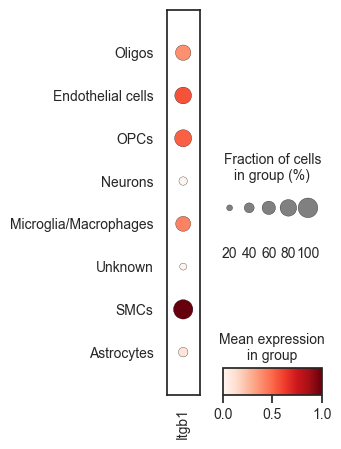

In [150]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [151]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.725970
Endothelial cells               0.811200
OPCs                            0.831683
Neurons                         0.321429
Microglia/Macrophages           0.698511
Unknown                         0.250000
SMCs                            0.984848
Astrocytes                      0.383372

In [152]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.381315           0.725970  Itgb1   
Endothelial cells             0.563962           0.811200  Itgb1   
OPCs                          0.525735           0.831683  Itgb1   
Neurons                       0.001988           0.321429  Itgb1   
Microglia/Macrophages         0.424303           0.698511  Itgb1   
Unknown                       0.000000           0.250000  Itgb1   
SMCs                          1.000000           0.984848  Itgb1   
Astrocytes                    0.099876           0.383372  Itgb1   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [153]:
# export
name='TabulaMuris2018'

In [154]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Angpt2

In [155]:
gene="Angpt2"

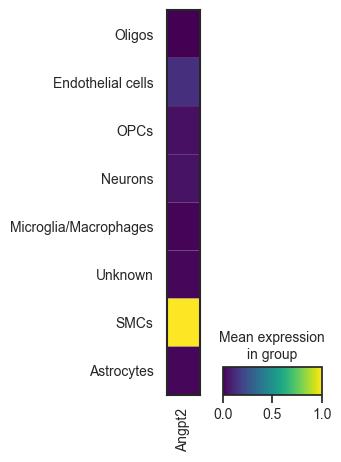

In [156]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [157]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000000
Endothelial cells             0.137721
OPCs                          0.040338
Neurons                       0.047293
Microglia/Macrophages         0.008049
Unknown                       0.016494
SMCs                          1.000000
Astrocytes                    0.016280

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


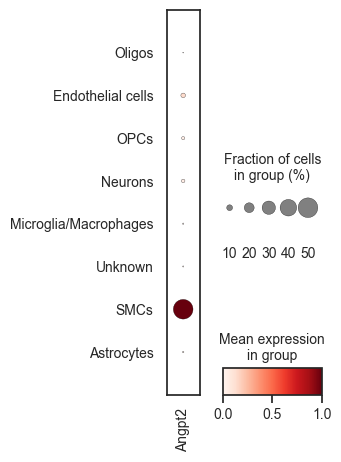

In [158]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [159]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.007589
Endothelial cells               0.072000
OPCs                            0.044554
Neurons                         0.051020
Microglia/Macrophages           0.014433
Unknown                         0.011364
SMCs                            0.500000
Astrocytes                      0.016166

In [160]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells    gene  \
clusters                                                            
Oligos                        0.000000           0.007589  Angpt2   
Endothelial cells             0.137721           0.072000  Angpt2   
OPCs                          0.040338           0.044554  Angpt2   
Neurons                       0.047293           0.051020  Angpt2   
Microglia/Macrophages         0.008049           0.014433  Angpt2   
Unknown                       0.016494           0.011364  Angpt2   
SMCs                          1.000000           0.500000  Angpt2   
Astrocytes                    0.016280           0.016166  Angpt2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [161]:
# export
name='TabulaMuris2018'

In [162]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Cdh5

In [163]:
gene="Cdh5"

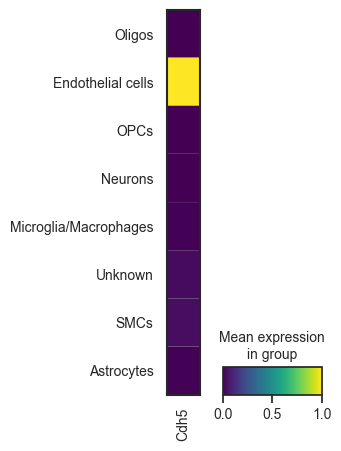

In [164]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [165]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Oligos                        0.000333
Endothelial cells             1.000000
OPCs                          0.000000
Neurons                       0.002560
Microglia/Macrophages         0.004602
Unknown                       0.028628
SMCs                          0.032378
Astrocytes                    0.005814

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


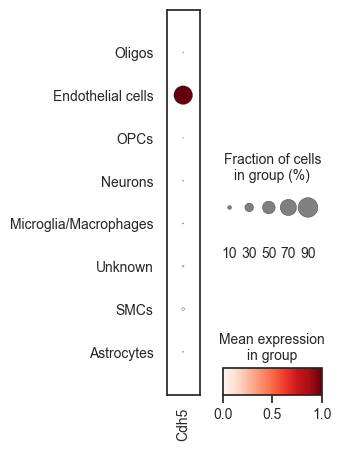

In [166]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [167]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Oligos                          0.011804
Endothelial cells               0.833600
OPCs                            0.009901
Neurons                         0.015306
Microglia/Macrophages           0.019473
Unknown                         0.034091
SMCs                            0.060606
Astrocytes                      0.016166

In [168]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
clusters                                                          
Oligos                        0.000333           0.011804  Cdh5   
Endothelial cells             1.000000           0.833600  Cdh5   
OPCs                          0.000000           0.009901  Cdh5   
Neurons                       0.002560           0.015306  Cdh5   
Microglia/Macrophages         0.004602           0.019473  Cdh5   
Unknown                       0.028628           0.034091  Cdh5   
SMCs                          0.032378           0.060606  Cdh5   
Astrocytes                    0.005814           0.016166  Cdh5   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [169]:
# export
name='TabulaMuris2018'

In [170]:
# Win
tek.to_csv(main_dir+'//P06_Foxf2_per_celltype//Other_genes_summarized//'+ datetime.date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [95]:
import magic
import scprep

In [97]:
sns.set_theme(style='white')

## ECs

In [98]:
gg = ["Foxf2","Foxo1","Nos3"]

In [104]:
adata_EC = adata[adata.obs.cell_type == "Endothelial cells"]

In [105]:
adata_EC

View of AnnData object with n_obs × n_vars = 625 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [106]:
adata_EC.layers

LayersView with keys: counts, normalized

In [107]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [108]:
cutoff_var = None

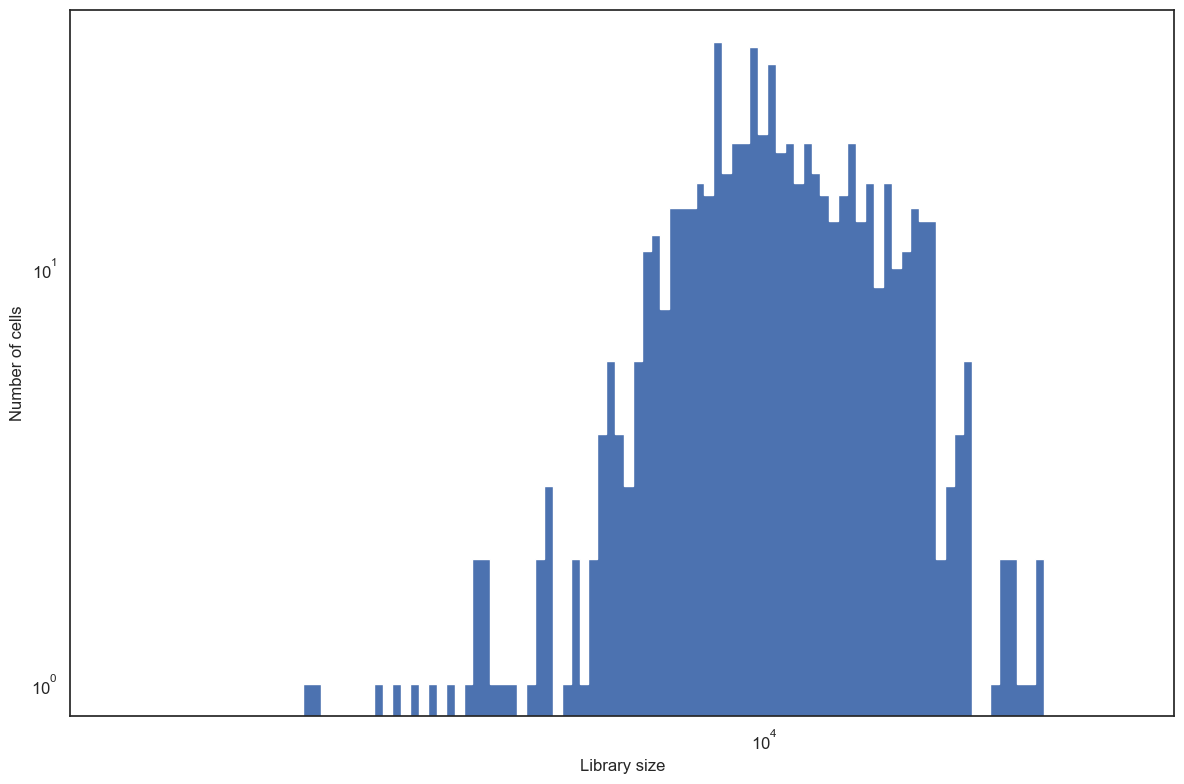

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [109]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [111]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [112]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [113]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [114]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 625 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 2.11 seconds.
  Calculating imputation...
Calculated MAGIC in 2.19 seconds.
CPU times: total: 4.8 s
Wall time: 2.19 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [115]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.9600462881967134

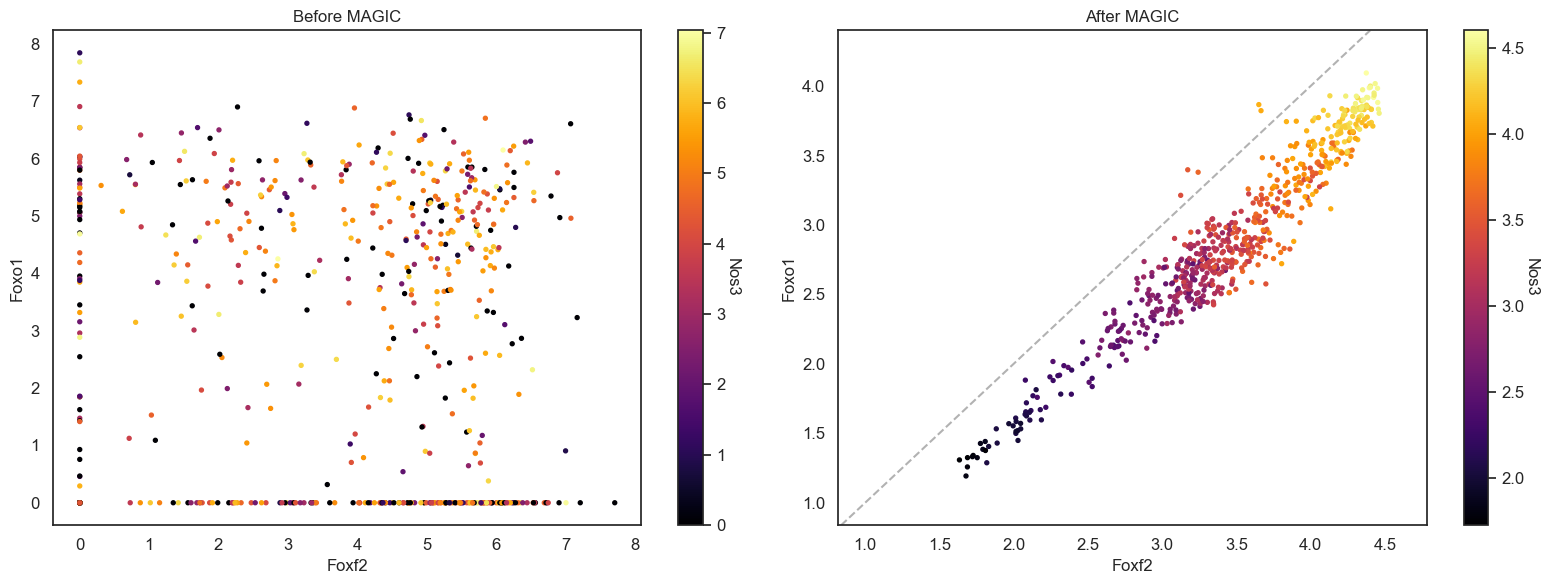

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [126]:
# no pericytes in dataset

## SMCs

In [127]:
gg = ["Foxf2","Foxo1","Nos3"]

In [128]:
adata_EC = adata[adata.obs.cell_type == "SMCs"]

In [129]:
adata_EC

View of AnnData object with n_obs × n_vars = 132 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [130]:
adata_EC.layers

LayersView with keys: counts, normalized

In [131]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [132]:
cutoff_var = None

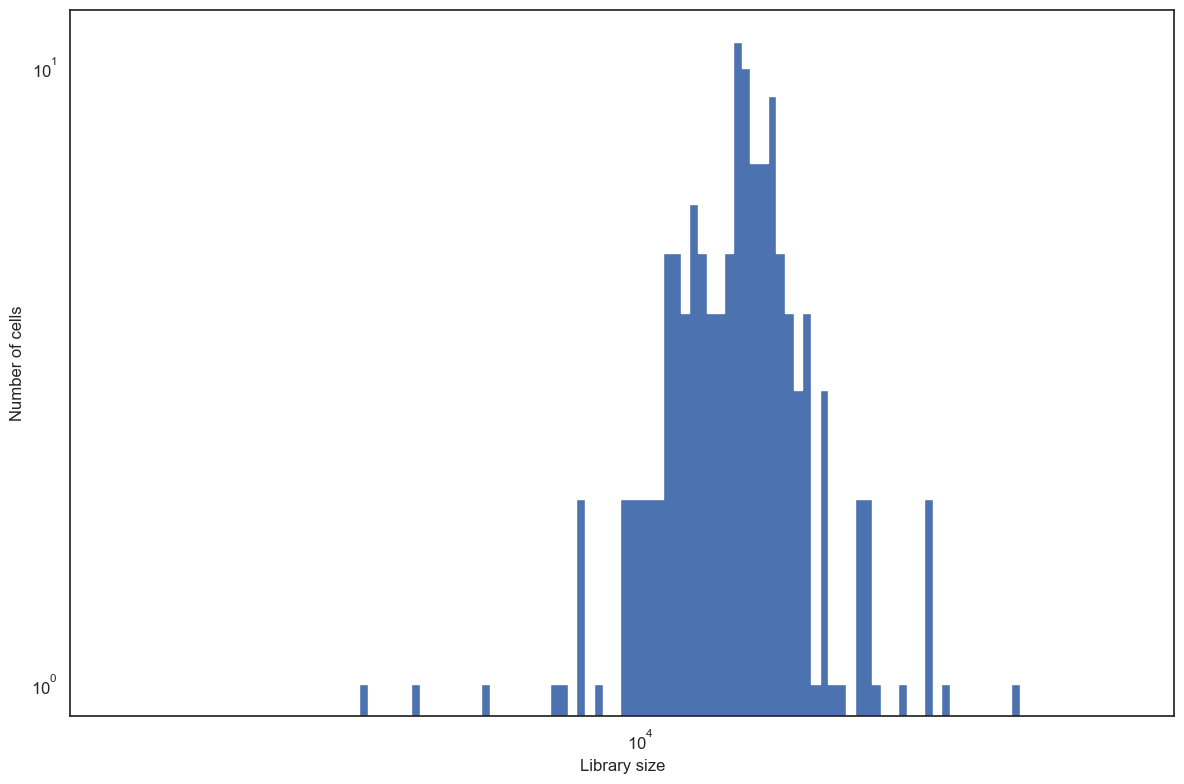

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [133]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [134]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [135]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [136]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [137]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 132 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.95 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.96 seconds.
  Calculating imputation...
Calculated MAGIC in 1.03 seconds.
CPU times: total: 2.36 s
Wall time: 1.03 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [138]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.17322498013054155

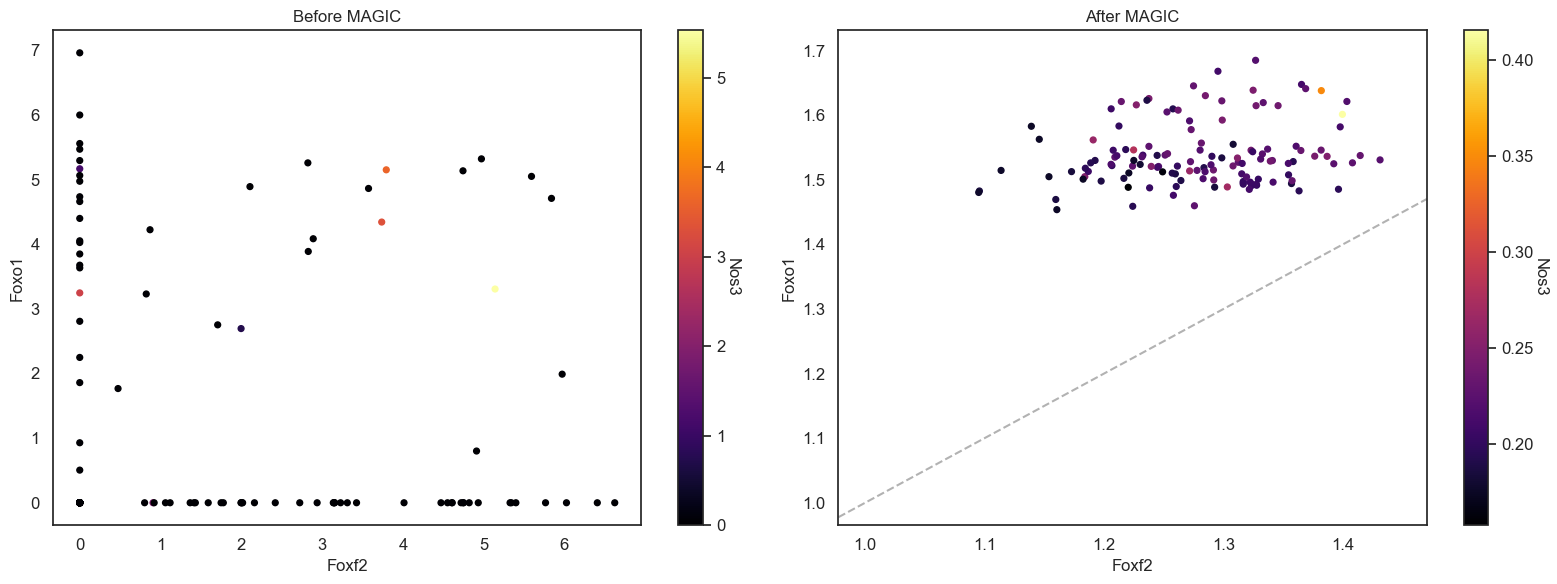

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [143]:
adata

View of AnnData object with n_obs × n_vars = 7315 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [145]:
#matrix = pd.DataFrame(adata.X) # not compatible with sparse 
matrix = adata.X
#matrix.columns = ad_merged.var.index.tolist()

In [146]:
cutoff_var = 700

C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\scprep\plot\histogram.py:180: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(cutoff, color="red")


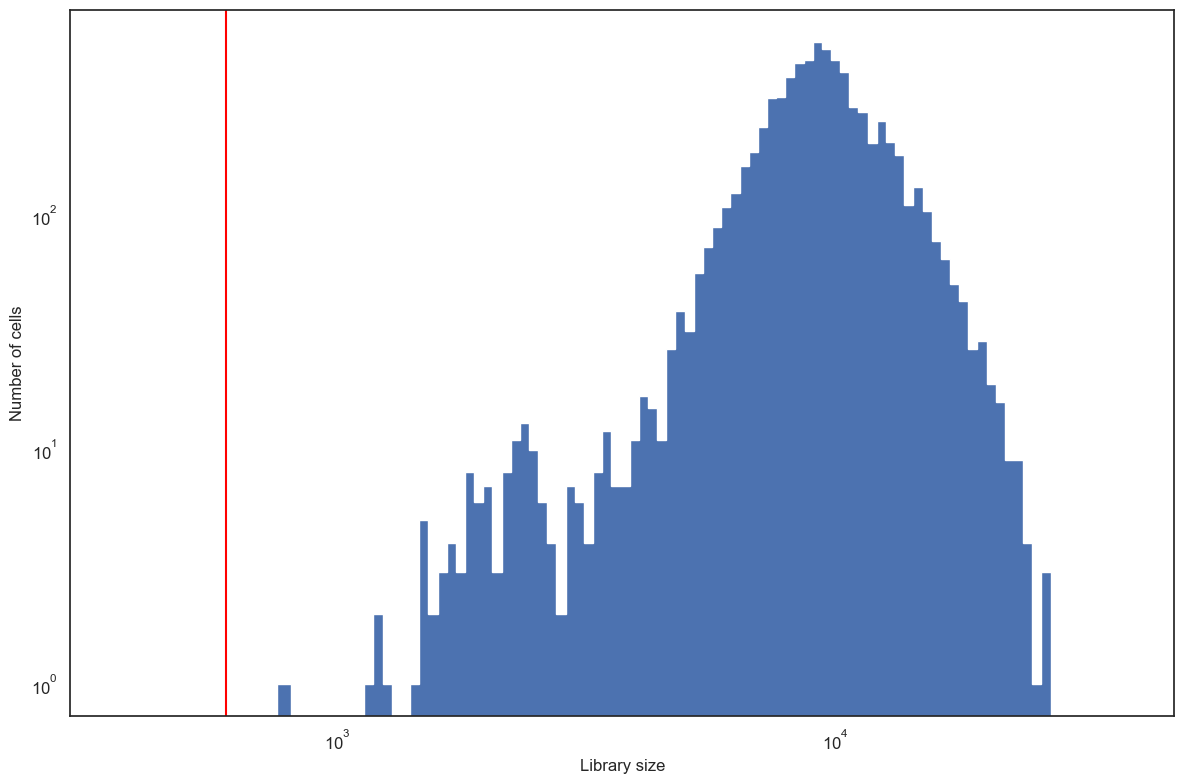

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [147]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [148]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [150]:
adata.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [151]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [152]:
%%time
emt_magic = magic_op.fit_transform(adata, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 7315 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 12.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.55 seconds.
    Calculating affinities...
    Calculated affinities in 4.47 seconds.
  Calculated graph and diffusion operator in 21.63 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 21.85 seconds.
CPU times: total: 24.1 s
Wall time: 21.9 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [153]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.5848404499977796

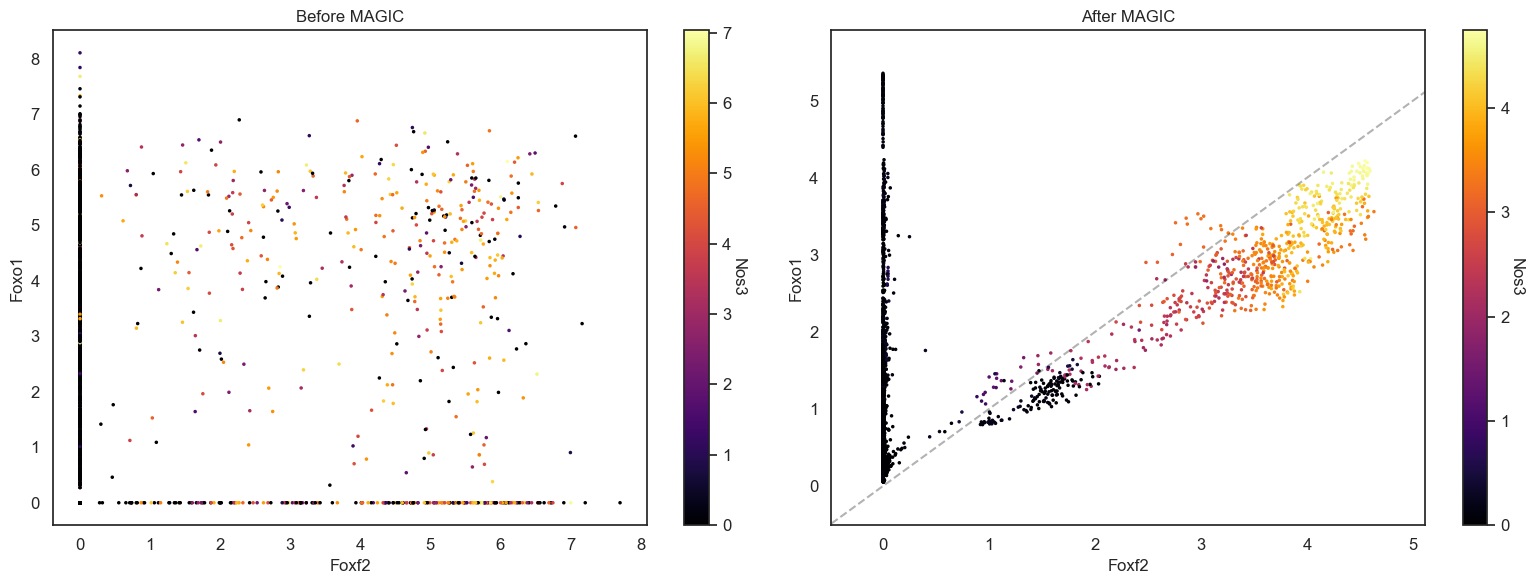

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata[:,'Foxf2'].X.todense(), y=adata[:,'Foxo1'].X.todense(), c=adata[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Session Info

In [156]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2